In [201]:
from commonfunctions import *
from sklearn import svm, datasets
import sklearn.model_selection as model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from scipy.signal import argrelextrema


In [202]:
import cv2
import os

def extract_hog_features(img):
    target_img_size = (64, 64)
    img = cv2.resize(img, target_img_size)
    win_size = (64, 64)
    cell_size = (8, 8)
    block_size_in_cells = (2, 2)
    
    block_size = (block_size_in_cells[1] * cell_size[1], block_size_in_cells[0] * cell_size[0])
    block_stride = (cell_size[1], cell_size[0])
    nbins = 9  # Number of orientation bins
    hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, nbins)
    h = hog.compute(img)
    h = h.flatten()
    return h.flatten()
def feature_extraction_hog(images):
    feature = []
    for img in images:
        img = img.astype('uint8')
        img = cv2.resize(img, (64, 64), cv2.INTER_AREA)
        featuresHog = extract_hog_features(img.astype('uint8'))
        feature.append(featuresHog)
    return feature
from skimage.filters import threshold_mean

def local_binarize(img, block_size = 35, offset_val = 10):
    img=img_as_ubyte(img)
    return img < threshold_otsu(img)


def load_images_from_folder(folders):
    images = []
    y=[]
    i = 1
    for folder in folders:   
        for filename in os.listdir(folder):
            img = io.imread(os.path.join(folder,filename), as_gray = True)
            if img is not None:

                images.append(local_binarize(img))
                y.append(i)
        i+=1
    return images, y

from skimage import transform
from skimage.color import rgb2gray
# from skimage.feature import match_descriptors, plot_matches, SIFT

def feature_extraction_sift(images):
    feature = []
    for img in images:
        descriptor_extractor = SIFT()
        descriptor_extractor.detect_and_extract(img)
        keypoints1 = descriptor_extractor.keypoints
        descriptors1 = descriptor_extractor.descriptors
        feature.append(descriptors1)
        print(keypoints1,descriptors1)
    return feature       

def process_Hog():
    
    images, y = load_images_from_folder(["N:\Downloads\ACdata_base\\1","N:\Downloads\ACdata_base\\2","N:\Downloads\ACdata_base\\3","N:\Downloads\ACdata_base\\4","N:\Downloads\ACdata_base\\5","N:\Downloads\ACdata_base\\6","N:\Downloads\ACdata_base\\7","N:\Downloads\ACdata_base\\8","N:\Downloads\ACdata_base\\9"])
    features = feature_extraction_hog(images)
    return features, y

def process_Sift():
    images, y = load_images_from_folder(["N:\Downloads\ACdata_base\\1","N:\Downloads\ACdata_base\\2","N:\Downloads\ACdata_base\\3","N:\Downloads\ACdata_base\\4","N:\Downloads\ACdata_base\\5","N:\Downloads\ACdata_base\\6","N:\Downloads\ACdata_base\\7","N:\Downloads\ACdata_base\\8","N:\Downloads\ACdata_base\\9"])
    features = feature_extraction_sift(images)
    return features, y

In [203]:

X, y = process_Hog()
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2


In [204]:
poly = svm.SVC(kernel='rbf', degree=3, C=5).fit(X_train, y_train)
poly_pred = poly.predict(X_test)

In [205]:
poly_accuracy = accuracy_score(y_test, poly_pred)
poly_f1 = f1_score(y_test, poly_pred, average='weighted')
print('Accuracy (Polynomial Kernel): ', "%.2f" % (poly_accuracy*100))
print('F1 (Polynomial Kernel): ', "%.2f" % (poly_f1*100))


Accuracy (Polynomial Kernel):  86.05
F1 (Polynomial Kernel):  85.88


In [206]:
def find_ref_lengths(img):
    white_runs = []
    black_runs = []
    for col in img.T:
        #add 0 at the start and end to handle the length
        bounded = np.hstack(([0], col, [0]))
        #get the first difference
        difs = np.diff(bounded)
        #a run of ones starts at (1) and ends at (-1)
        run_starts, = np.where(difs > 0)
        run_ends, = np.where(difs < 0)
        
        #Append the runs:
        white_runs.extend(run_ends - run_starts)
        black_runs.extend(run_starts[1:] - run_ends[:-1])
    
    line_width = np.bincount(white_runs).argmax()
    line_spacing = np.bincount(black_runs).argmax()
     
    return line_width, line_spacing, white_runs


In [218]:
def baseline(img):
    horizontal_projection = np.sum(img, axis=1)
    return np.argmax(horizontal_projection)

  
def processing_images(binary_img):
    img = rgb2gray(io.imread('N:\Downloads\ACdata_base\\8\\1308.jpg'))
    bw_img=binary_img
    baseline_i=baseline(bw_img)
    seeds=[]
    for j in range(bw_img.shape[1]-1):
        if(bw_img[baseline_i][j]==False and bw_img[baseline_i][j+1]==True):
            seeds.append(j+1)
    diacritics = bw_img
    for j in seeds:
        diacritics = flood_fill(diacritics, (baseline_i, j), False)
    text_only = bw_img != diacritics
    sobel_img = sobel(bw_img)
    skeletonized_img=skeletonize(bw_img)
    
    return sobel_img, skeletonized_img, diacritics, text_only

In [219]:
def get_max_freq(list):
    freq = {} 
    for item in list: 
        if (item in freq): 
            freq[item] += 1
        else: 
            freq[item] = 1
    wanted_value=0
    wanted_angle=0
    for key, value in freq.items():
        if wanted_value<value:
            wanted_value=value
            wanted_angle=key       
    return wanted_angle

In [220]:
def HVSL(bw_image):
    # hough line to detect lines in the photo
    tested_angles = np.linspace(np.pi, np.pi / 2, 2)
    h, theta, d = hough_line(bw_image, theta=tested_angles)
    origin = np.array((0, bw_image.shape[1]))
    # hough peaks to get those lines
    angles=[]
    for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
        y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
        angles.append(angle)
    angles = [angle * 180 / np.pi for angle in angles]
    return angles.count(180.0), angles.count(90.0)



2 2 73
6349.333333333333


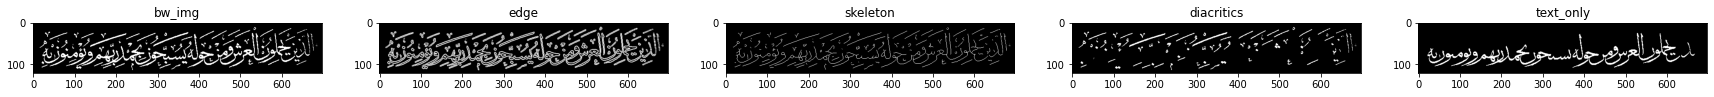

In [221]:
img = io.imread('N:\Downloads\ACdata_base\\8\\1306.jpg', 1)
bw_img=local_binarize(img)
line_width, line_space, _ = find_ref_lengths(bw_img)
print(line_width, line_space,baseline_i)

edge, skeleton, diacritics, text_only=processing_images(bw_img)

################### 1st feature ##################
vertical_lines, horizontal_lines = HVSL(edge)
ratio_pixels_HVL = np.count_nonzero(edge)/(vertical_lines + horizontal_lines)

################## ----------- ###################
print(ratio_pixels_HVL)
show_images([bw_img, edge, skeleton, diacritics, text_only],['bw_img', 'edge', 'skeleton', 'diacritics', 'text_only'])



In [222]:
# img=img_as_ubyte(bw_img)
# from PIL import Image, ImageChops

# def fill(img):
#     im_th = img.astype('uint8')
#     im_floodfill = im_th.copy()
#     h, w = im_th.shape[:2]
#     mask = np.zeros((h+2, w+2), np.uint8)
#     cv2.floodFill(im_floodfill, mask, (0,0), 255)
# #     im_floodfill_inv = cv2.bitwise_not(im_floodfill)
#     im_out = im_th == im_floodfill 
#     return im_out

# im=fill(img)
# show_images([img, im],['F1 image','F2 image'])
